In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
import pandas as pd
import os
from scipy.signal import medfilt
from astropy.wcs import WCS
import scipy.integrate as integrate
from astropy.coordinates import SkyCoord
from gwcs.wcstools import wcs_from_points
import astropy.coordinates as coord

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/'

Load in Sean's catalog to identify the stars

In [4]:
sdj_fits = fits.open(rootdir+'PG1522+101_final_objects.fits')

In [5]:
sdj_fits[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.12a          
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  753 /Number of bytes per row                         
NAXIS2  =                 4225 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   87 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [6]:
sdj_cat_arr = pd.DataFrame(sdj_fits[1].data).to_numpy()

In [7]:
qso_ra = sdj_cat_arr[0,5]
qso_dec = sdj_cat_arr[0,6]

In [8]:
qso_ra

231.1021728515625

In [9]:
qso_dec

9.974760055541992

In [7]:
sdj_redshifts = sdj_cat_arr[:,79]

In [8]:
sdj_stars_idx = np.where(sdj_redshifts==0)[0]

In [9]:
sdj_stars_ra = sdj_cat_arr[sdj_stars_idx][:,3]
sdj_stars_dec = sdj_cat_arr[sdj_stars_idx][:,4]
sdj_stars_mag = sdj_cat_arr[sdj_stars_idx][:,22]

In [10]:
def calc_phi(alpha_1, delta_1, alpha_2, delta_2):
    
    cos_phi = np.dot([np.cos(delta_1)*np.cos(alpha_1), np.cos(delta_1)*np.sin(alpha_1), np.sin(delta_1)],
                      [np.cos(delta_2)*np.cos(alpha_2), np.cos(delta_2)*np.sin(alpha_2), np.sin(delta_2)])
    
    phi = np.arccos(cos_phi)
    
    return phi

In [11]:
sdj_stars_theta = []

for i in range(len(sdj_stars_ra)):
    
    ra = sdj_stars_ra[i]*np.pi/180
    dec = sdj_stars_dec[i]*np.pi/180
        
    sdj_stars_theta.append((calc_phi(ra, dec, qso_ra*np.pi/180, qso_dec*np.pi/180)*units.rad).to(units.arcsecond).value)
    
sdj_stars_theta = np.array(sdj_stars_theta)

In [12]:
df_stars = pd.DataFrame(columns = ['RA', 'Dec', 'IMACS_R_mag', 'theta'])

In [13]:
df_stars['RA'] = sdj_stars_ra
df_stars['Dec'] = sdj_stars_dec
df_stars['IMACS_R_mag'] = sdj_stars_mag
df_stars['theta'] = sdj_stars_theta

In [14]:
df_alignment_stars = df_stars[(df_stars['theta']>100)&(df_stars['theta']<200)&(df_stars['IMACS_R_mag']>17)&(df_stars['IMACS_R_mag']<20)]

In [15]:
df_alignment_stars

,RA,Dec,IMACS_R_mag,theta
12,231.109953,9.938523,17.8197,133.338055
32,231.156817,9.970183,17.0084,194.446774
35,231.083652,10.009243,17.0249,140.433358
47,231.054064,9.967228,17.7887,172.716820
50,231.101468,9.94353,18.9135,112.456335
82,231.134913,9.982415,18.7525,119.308187
93,231.148662,9.997388,17.7399,183.857218
96,231.13817,9.936295,19.2587,188.325666
103,231.078253,9.93826,18.9172,156.396779


Load in the full catalog

In [16]:
def deg_to_hms_dms(ra_dec):
    
    ra = Angle(ra_dec[0], units.deg).hms
    dec = Angle(ra_dec[1], units.deg).dms
    
    return [ra, dec]

In [17]:
df = pd.read_csv(rootdir+'ldss_photometry_final.dat')

In [18]:
df

,RA,Dec,f160w_mag,f140w_mag,pseudo_g_mag,pseudo_r_mag,pseudo_i_mag,z
0,231.087323,9.960302,-1.00,19.63,-1.0,-1.0,-1.0,-1.0
1,231.087641,9.959497,-1.00,18.65,-1.0,-1.0,-1.0,-1.0
2,231.117408,9.965167,-1.00,19.66,-1.0,-1.0,-1.0,-1.0
3,231.118858,9.964090,-1.00,18.02,-1.0,-1.0,-1.0,-1.0
4,231.091122,9.953285,-1.00,22.92,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...
1109,231.092249,9.987659,22.17,22.68,-1.0,-1.0,-1.0,-1.0
1110,231.115917,9.960264,23.49,23.78,-1.0,-1.0,-1.0,-1.0
1111,231.099336,9.989730,22.56,22.30,-1.0,-1.0,-1.0,-1.0
1112,231.087405,9.986115,-1.00,23.89,-1.0,-1.0,-1.0,-1.0


Compute the separation of all objects from the QSO

In [19]:
df['theta'] = -1*np.ones(len(df))

In [20]:
for i in range(len(df)):

    ra = Angle(df.loc[i]['RA'], units.deg).rad
    dec = Angle(df.loc[i]['Dec'], units.deg).rad

    df.loc[i,'theta'] = (calc_phi(ra, dec, qso_ra*np.pi/180, qso_dec*np.pi/180)*units.rad).to(units.arcsecond).value

In [21]:
df

,RA,Dec,f160w_mag,f140w_mag,pseudo_g_mag,pseudo_r_mag,pseudo_i_mag,z,theta
0,231.087323,9.960302,-1.00,19.63,-1.0,-1.0,-1.0,-1.0,74.036769
1,231.087641,9.959497,-1.00,18.65,-1.0,-1.0,-1.0,-1.0,75.328043
2,231.117408,9.965167,-1.00,19.66,-1.0,-1.0,-1.0,-1.0,64.113375
3,231.118858,9.964090,-1.00,18.02,-1.0,-1.0,-1.0,-1.0,70.535991
4,231.091122,9.953285,-1.00,22.92,-1.0,-1.0,-1.0,-1.0,86.672083
...,...,...,...,...,...,...,...,...,...
1109,231.092249,9.987659,22.17,22.68,-1.0,-1.0,-1.0,-1.0,58.261841
1110,231.115917,9.960264,23.49,23.78,-1.0,-1.0,-1.0,-1.0,71.402924
1111,231.099336,9.989730,22.56,22.30,-1.0,-1.0,-1.0,-1.0,54.824151
1112,231.087405,9.986115,-1.00,23.89,-1.0,-1.0,-1.0,-1.0,66.428578


Now begin sorting, let us see the distribution of $\theta_{QSO}$

Text(0, 0.5, 'Counts')

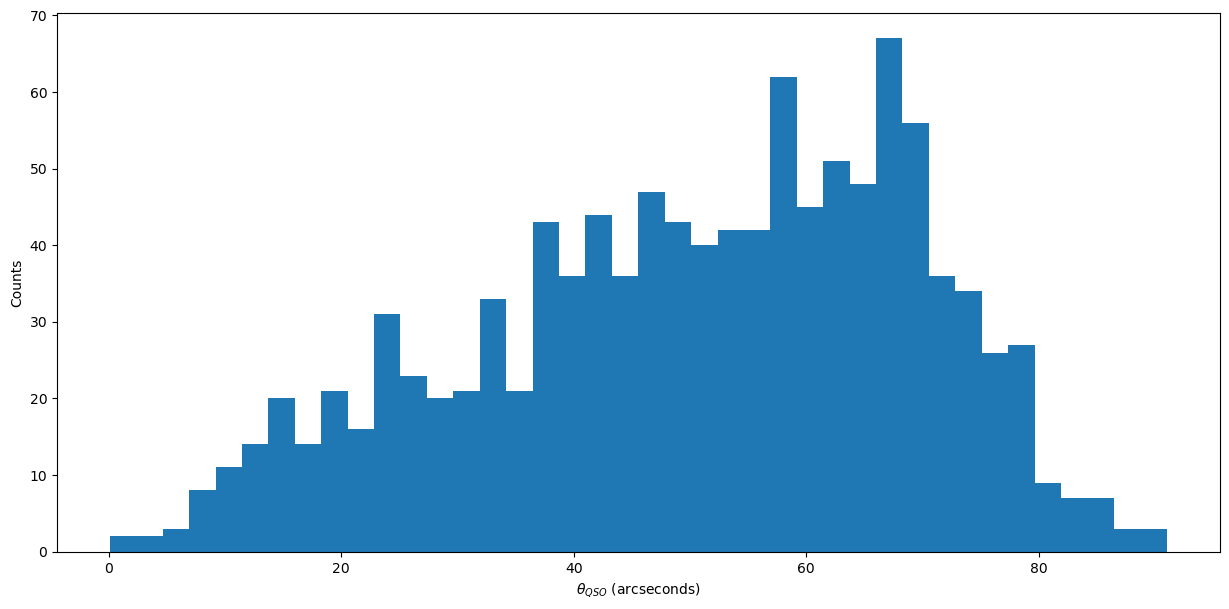

In [22]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.hist(df['theta'], bins=40)

ax.set_xlabel(r'$\theta_{QSO}$ (arcseconds)')
ax.set_ylabel('Counts')

In [23]:
theta_partitions = [0,25,50,75,100]

In [24]:
df_sorted = pd.DataFrame(columns=df.columns)

In [25]:
for i in range(len(theta_partitions)-1):
    
    theta_min = theta_partitions[i]
    theta_max = theta_partitions[i+1]
    
    df_slice = df.loc[(df['theta']>=theta_min)&(df['theta']<=theta_max)].sort_values('f160w_mag')
        
    df_sorted = df_sorted.append(df_slice)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_20614/840781410.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.append(df_slice)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_20614/840781410.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.append(df_slice)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_20614/840781410.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.append(df_slice)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_20614/840781410.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sort

In [26]:
df_sorted

,RA,Dec,f160w_mag,f140w_mag,pseudo_g_mag,pseudo_r_mag,pseudo_i_mag,z,theta
461,231.106859,9.977688,-1.00,23.04,-1.0,-1.0,-1.0,-1.0,19.677603
359,231.102481,9.980198,-1.00,23.73,-1.0,-1.0,-1.0,-1.0,19.606745
462,231.100021,9.975330,-1.00,23.60,-1.0,-1.0,-1.0,-1.0,7.901759
366,231.096478,9.978184,-1.00,24.14,-1.0,-1.0,-1.0,-1.0,23.655196
736,231.103785,9.968458,-1.00,22.55,-1.0,-1.0,-1.0,-1.0,23.397418
...,...,...,...,...,...,...,...,...,...
16,231.092749,9.955428,22.76,22.08,-1.0,-1.0,-1.0,-1.0,77.202623
68,231.080630,9.981743,22.91,21.59,-1.0,-1.0,-1.0,-1.0,80.412294
5,231.091197,9.952817,23.04,21.23,-1.0,-1.0,-1.0,-1.0,88.061051
33,231.119600,9.961566,23.11,22.65,-1.0,-1.0,-1.0,-1.0,77.938865


In [27]:
df_sorted[df_sorted['z']==0.6780]

,RA,Dec,f160w_mag,f140w_mag,pseudo_g_mag,pseudo_r_mag,pseudo_i_mag,z,theta
680,231.095997,9.967605,20.77,20.68,26.62,25.23,24.83,0.678,33.806604


In [29]:
df_sorted[df_sorted['z']==0.7293]

,RA,Dec,f160w_mag,f140w_mag,pseudo_g_mag,pseudo_r_mag,pseudo_i_mag,z,theta
496,231.108912,9.975914,20.21,20.28,24.16,23.3,22.79,0.7293,24.251508


In [30]:
df_sorted[df_sorted['z']==1.0959]

,RA,Dec,f160w_mag,f140w_mag,pseudo_g_mag,pseudo_r_mag,pseudo_i_mag,z,theta
280,231.099772,9.981098,22.82,22.55,27.27,27.02,26.37,1.0959,24.351755


Now, retain only galaxies without a MUSE redshift with magnitude between 14 and 21

In [27]:
df_gals = df_sorted.loc[((df_sorted['z']==-1.0)&(df_sorted['f160w_mag']>=14)&(df_sorted['f160w_mag']<=21))]
df_gals = df_gals.drop('z', axis=1)

In [28]:
ra_sorted = []
dec_sorted = []
theta_sorted = []
mag_sorted = []

In [29]:
for i in range(len(theta_partitions)-1):
    
    theta_min = theta_partitions[i]
    theta_max = theta_partitions[i+1]
    
    df_slice = df_gals.loc[(df_gals['theta']>=theta_min)&(df_gals['theta']<=theta_max)].sort_values('f160w_mag')
            
    theta_sorted.append(list(df_slice['theta']))
    mag_sorted.append(list(df_slice['f160w_mag']))
    ra_sorted.append(list(df_slice['RA']))
    dec_sorted.append(list(df_slice['Dec']))

In [30]:
df_gals

,RA,Dec,f160w_mag,f140w_mag,pseudo_g_mag,pseudo_r_mag,pseudo_i_mag,theta
416,231.102199,9.974757,15.60,15.72,-1.00,-1.00,-1.00,0.093832
392,231.101810,9.973777,18.91,18.93,-1.00,-1.00,-1.00,3.765575
394,231.104325,9.975240,19.02,19.16,23.60,23.13,22.92,7.824116
380,231.102861,9.972801,19.16,19.44,-1.00,-1.00,-1.00,7.463561
388,231.100757,9.977255,19.50,19.32,25.44,25.14,25.09,10.288531
...,...,...,...,...,...,...,...,...
1052,231.121092,9.964425,20.40,22.49,-1.00,-1.00,-1.00,76.708324
899,231.090440,9.956808,20.50,20.52,-1.00,-1.00,-1.00,76.857354
18,231.093343,9.954242,20.53,20.41,-1.00,-1.00,-1.00,80.226097
28,231.120105,9.963045,20.78,21.77,-1.00,-1.00,-1.00,76.295439


Plot the distribution of galaxy magnitudes in each bin away from the quasar

In [31]:
colors = ['salmon', 'olive', 'sandybrown', 'lightblue', 'violet']

In [32]:
N_gals = 0

21
28
44
9


Text(0, 0.5, 'Magnitude')

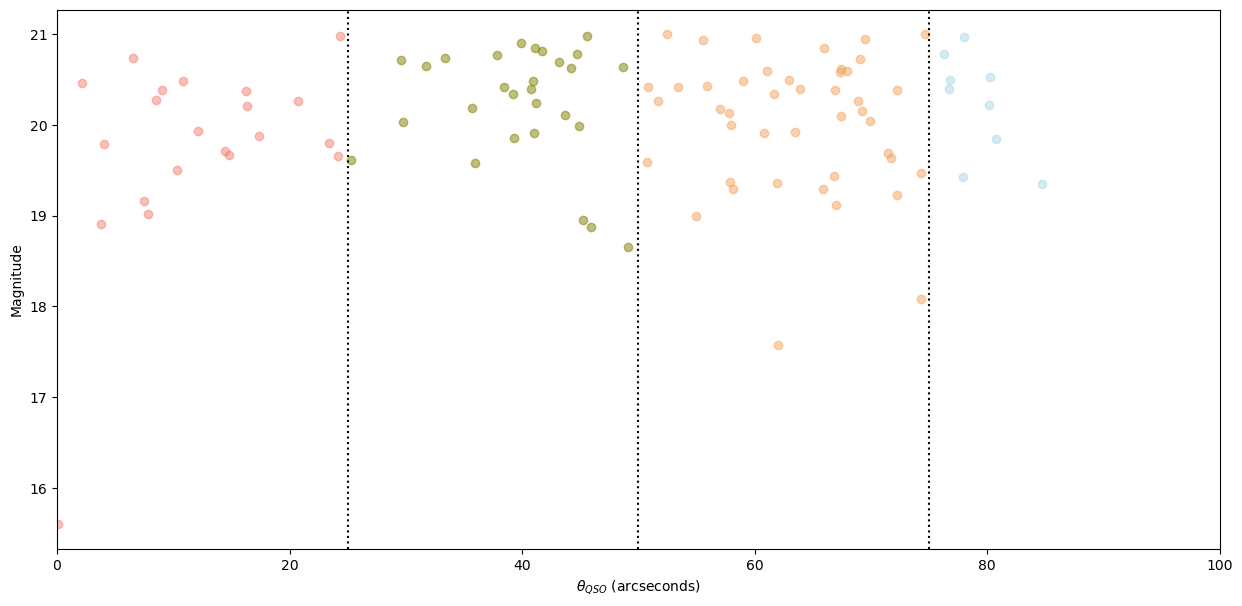

In [33]:
fig, ax = plt.subplots(1, figsize=(15,7))

for i in range(len(theta_sorted)):
    print(len(theta_sorted[i]))
    N_gals += len(theta_sorted[i])
    ax.scatter(theta_sorted[i], mag_sorted[i], color=colors[i], alpha=.5)
    
for j in range(1,len(theta_partitions)-1):
    ax.axvline(theta_partitions[j], color='black', linestyle=':')

ax.set_xlim(0,100)

ax.set_xlabel(r'$\theta_{QSO}$ (arcseconds)')
ax.set_ylabel('Magnitude')

Write a regions file to visalize this properly

In [34]:
colors_ds9 = ['pink', 'green', 'yellow', 'cyan', 'white']

In [35]:
with open(rootdir+'ldss_galaxies.reg', 'w') as f:
    
    # Make the annular regions
    #for i in range(1, len(theta_partitions)-1):
    #    f.write('\ncircle(15:24:24.53,+09:58:29.1, {}") #color = gray'.format(theta_partitions[i]))
        
    # Mark the alignment stars
    for i in range(len(df_alignment_stars)):

        idx = df_alignment_stars.index[i]

        ra = Angle(df_alignment_stars.loc[idx,'RA'], units.deg).hms
        dec = Angle(df_alignment_stars.loc[idx,'Dec'], units.deg).dms
        mag = df_alignment_stars.loc[idx,'IMACS_R_mag']

        ra_label = '%02d'%int(ra[0])+':'+'%02d'%int(ra[1])+':'+'%.2f'%np.round(ra[2],2)
        dec_label = '+'+'%02d'%int(dec[0])+':'+'%02d'%int(dec[1])+':'+'%04.1f'%np.round(dec[2],1)

        f.write('\ncircle('+ra_label+','+dec_label+', 1.0") #color = ' + 'red' + ' text = {'+'%.4f'%np.round(mag, 2)+'}')

    # Mark the galaxies
    for i in range(len(ra_sorted)):

        ra_list = ra_sorted[i]
        dec_list = dec_sorted[i]
        mag_list = mag_sorted[i]

        for j in range(len(ra_list)):

            ra = Angle(ra_list[j], units.deg).hms
            dec = Angle(dec_list[j], units.deg).dms
            mag = mag_list[j]

            ra_label = '%02d'%int(ra[0])+':'+'%02d'%int(ra[1])+':'+'%.2f'%np.round(ra[2],2)
            dec_label = '+'+'%02d'%int(dec[0])+':'+'%02d'%int(dec[1])+':'+'%04.1f'%np.round(dec[2],1)

            f.write('\ncircle('+ra_label+','+dec_label+', 1.0") #color = ' + colors_ds9[i] + ' text = {'+'%.4f'%np.round(mag, 2)+'}')    

Next, the galaxies. First assign priority scores to the galaxies. The brightest galaxy in the closest bin to the quasar will have a priority of -1, while the dimmest will have a priority of +1.

In [36]:
priorities_sorted = []

In [37]:
count = 0
bin_size = len(theta_sorted[0])

for i in range(len(theta_sorted)):
    priorities_sorted.append([])
    for j in range(len(theta_sorted[i])):
        
        priorities_sorted[i].append(-1 + 2*(count/(bin_size-1)))
        
        # This puts the brightest closest galaxy at -1 and the dimmest farthest at 1
        #priorities_sorted[i].append(-1 + 2*(count/(N_gals-1)))
        count += 1

Finally print out the galaxy catalog

In [1]:
with open(rootdir+'PG1522+101_ldss.cat', 'w') as f:
    
    # First write out the alignment stars
    
    f.write('#Reference ID RA Dec IMACS_R_mag theta')
    
    for i in range(len(df_alignment_stars)):

        idx = df_alignment_stars.index[i]

        ra = Angle(df_alignment_stars.loc[idx,'RA'], units.deg).hms
        dec = Angle(df_alignment_stars.loc[idx,'Dec'], units.deg).dms
        mag = df_alignment_stars.loc[idx,'IMACS_R_mag']
        theta = df_alignment_stars.loc[idx, 'theta']

        ra_label = '%02d'%int(ra[0])+':'+'%02d'%int(ra[1])+':'+'%.2f'%np.round(ra[2],2)
        dec_label = '+'+'%02d'%int(dec[0])+':'+'%02d'%int(dec[1])+':'+'%04.2f'%np.round(dec[2],1)

        f.write('\n*star' + str(i) + ' ' + ra_label + ' ' + dec_label + ' # ' + 
              '%.2f'%np.round(mag, 2) + '; theta = ' + '%.2f'%np.round(theta, 2))
        
    # Then write out the galaxies
    
    f.write('\n#Object ID RA Dec Priority HST_H_mag theta')
    
    for i in range(len(theta_partitions)-1):

        theta_min = theta_partitions[i]
        theta_max = theta_partitions[i+1]

        df_slice = df_gals.loc[(df_gals['theta']>=theta_min)&(df_gals['theta']<=theta_max)].sort_values('f160w_mag')

        idx_list = df_slice.index

        for j in range(len(priorities_sorted[i])):

            idx = idx_list[j]
            ra = Angle(ra_sorted[i][j], units.deg).hms
            dec = Angle(dec_sorted[i][j], units.deg).dms
            mag = mag_sorted[i][j]   
            theta = theta_sorted[i][j]
            p = priorities_sorted[i][j]
            
            ra_label = '%02d'%int(ra[0])+':'+'%02d'%int(ra[1])+':'+'%.2f'%np.round(ra[2],2)
            dec_label = '+'+'%02d'%int(dec[0])+':'+'%02d'%int(dec[1])+':'+'%04.2f'%np.round(dec[2],1)

            f.write('\n@' + str(idx) + ' ' + ra_label + ' ' + dec_label + ' ' + '%.2f'%np.round(p, 2) + ' # ' + 
                  '%.2f'%np.round(mag, 2) + ' ' + '%.2f'%np.round(theta, 2))            

NameError: name 'rootdir' is not defined